In [1]:
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.models import Model
from keras.applications.resnet50 import ResNet50
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

Couldn't import dot_parser, loading of dot files will not be possible.


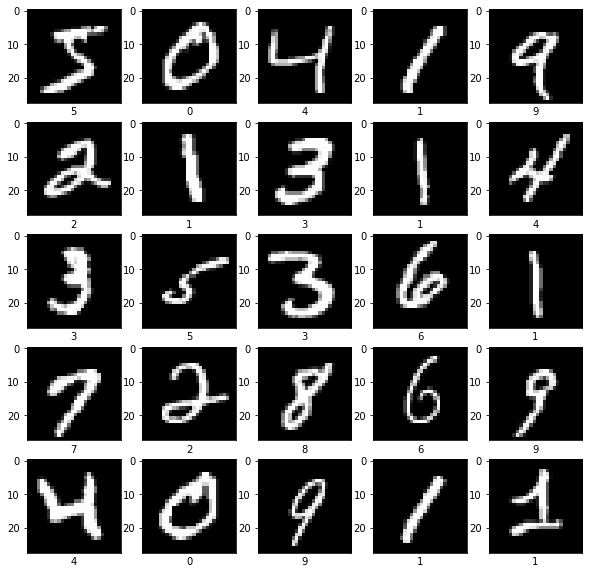

In [10]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [2]:
#train_images = tf.pad(train_images, [[0, 0], [2,2], [2,2], [0,0]])
#test_images = tf.pad(test_images, [[0, 0], [2,2], [2,2], [0,0]])
def padImage(image, pixels=5):
    bottom = image[-pixels:]
    top = image[:pixels]

    img = np.insert(image, 0, bottom, 0)
    img = np.insert(img, len(img), top, 0)
    #img = np.insert(img, [0], [0] * pixels, 1)
    #img = np.insert(img, [-1], [0] * pixels, 1)
    return img

In [3]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = (train_images / 255.0).astype(np.float32), test_images.astype(np.float32) / 255.0

#train_images = train_images.reshape(len(train_images), 28, 28, 1)
#test_images = test_images.reshape(len(test_images), 28, 28, 1)

train_images = np.stack((train_images,)*3, axis=-1)
test_images = np.stack((test_images,)*3, axis=-1)
print(train_images.shape)

(60000, 28, 28, 3)


In [4]:
### THE PAD HAS TO BE DONE IN THE
### POLAR SPACE

# 20 is the ceiling of (14 * sqrt(2))
X_train_polar = [cv.linearPolar(x, tuple(np.array(x.shape[:2])/2), 20, cv.WARP_FILL_OUTLIERS) for x in train_images]
X_train_polar = [padImage(x, pixels=2) for x in X_train_polar]
X_train_polar = np.array(X_train_polar)[...]
X_train_polar = tf.pad(X_train_polar, [[0, 0], [0,0], [2,2], [0,0]]) # pad 2 pixels each side to make 32x32

X_test_polar = [cv.linearPolar(x, tuple(np.array(x.shape[:2])/2), 20, cv.WARP_FILL_OUTLIERS) for x in test_images]
X_test_polar = [padImage(x, pixels=5) for x in X_test_polar]
X_test_polar = np.array(X_test_polar)[...]
X_test_polar = tf.pad(X_test_polar, [[0, 0], [0,0], [2,2], [0,0]]) # pad 2 pixels each side to make 32x32

# Rotate test set
X_test_r_polar = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in test_images]
X_test_r_polar = [cv.linearPolar(x, tuple(np.array(x.shape[:2])/2), 20, cv.WARP_FILL_OUTLIERS) for x in X_test_r_polar]
X_test_r_polar = [padImage(x, pixels=5) for x in X_test_r_polar]
X_test_r_polar = np.array(X_test_r_polar)[...]
X_test_r_polar = tf.pad(X_test_r_polar, [[0, 0], [0,0], [2,2], [0,0]]) # pad 2 pixels each side to make 32x32

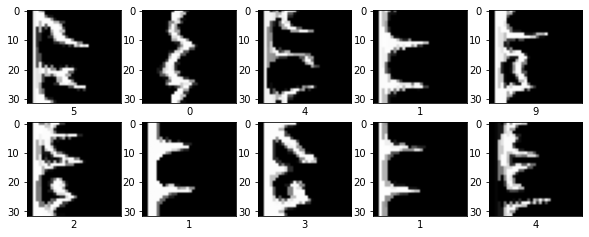

In [13]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(X_train_polar[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [6]:
model = models.Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model.add(layers.Dense(10, activation = 'softmax'))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False


In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
history = model.fit(X_train_polar, train_labels, epochs=10, batch_size=128)

model_path = 'models/resnet_50_test'
model.save()

Epoch 1/10
469/469 [==============================] - 68s 139ms/step - loss: 1.5274 - accuracy: 0.5285
Epoch 2/10
469/469 [==============================] - 71s 152ms/step - loss: 0.7294 - accuracy: 0.7946
Epoch 3/10
163/469 [=========>....................] - ETA: 47s - loss: 0.6023 - accuracy: 0.8305

KeyboardInterrupt: 

In [ ]:
if history:
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    plt.plot(history.history['accuracy'], label=f'accuracy = {train_acc:.2f}')
    plt.plot(history.history['val_accuracy'], label = f'val_accuracy = {val_acc:.2f}')
    plt.title('O/O CIFAR10 Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

# Validation on non-rotated data

In [ ]:
model.evaluate(X_test_polar, test_labels, verbose=2)

# Validation on randomly rotated data

In [ ]:
model.evaluate(X_test_r_polar, test_labels, verbose=2)